In [1]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

# 適宜自分のApplicationPATHまで変更
APP_PATH = '/content/drive/Othercomputers/LAPTOP-3BHDM0TI/windows_research/workspace/research/carbon-steel-tissue-analysis'

import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import albumentations as A
# from albumentations.pytorch import ToTensor removed
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
# from PIL import Image
# from torch import nn
import zipfile

import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
TRAIN_PATH = APP_PATH + '/stage1_train'
CHECKPOINT_PATH = APP_PATH + '/data/model'

os.chdir(APP_PATH)
!pwd
!ls -al

Mounted at /content/drive
/content/drive/Othercomputers/LAPTOP-3BHDM0TI/windows_research/workspace/research/carbon-steel-tissue-analysis
total 81012
drwx------ 2 root root     4096 May 24 09:49 app
drwx------ 2 root root     4096 May 24 09:49 bin
-rw------- 1 root root       85 May 25 12:20 cell.txt
drwx------ 2 root root     4096 May 24 09:52 data
drwx------ 2 root root     4096 May 24 09:49 dataset_npz
-rw------- 1 root root       48 May  8 09:58 .gitignore
-rw------- 1 root root      265 May  8 09:51 Makefile
-rw------- 1 root root      358 May  8 09:37 README.md
drwx------ 2 root root     4096 May 25 11:02 stage1_train
-rw------- 1 root root 82923446 May 25 11:01 stage1_train.zip
drwx------ 2 root root     4096 May 24 00:57 tmp
-rw------- 1 root root     5353 May 26 13:52 TODO.txt


torch.Size([3, 256, 256])
torch.Size([256, 256, 1])
[188, 454, 335]


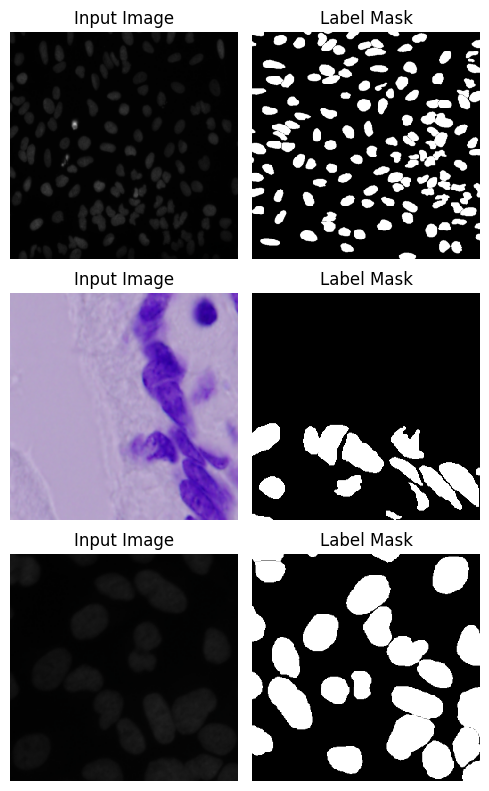

In [2]:
#画像データ拡張の関数
def get_train_transform():
   return A.Compose(
       [
        #リサイズ(こちらはすでに適用済みなのでなくても良いです)
        A.Resize(256, 256),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #水平フリップ（pはフリップする確率）
        A.HorizontalFlip(p=0.25),
        #垂直フリップ
        A.VerticalFlip(p=0.25),
        # ToTensor()
        ToTensorV2(),
        ])

#Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self,path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)

        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            #画像データの取得
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(256,256))
            
            mask = self.get_mask(mask_folder, 256, 256 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            # print("mask:{}".format(mask[0].dim())) # 2次元
            
            # 次元の順番を入れ替えているだけだから手動で修正する
            ################################
            # x = torch.view_as_real(mask)
            ################################
            # mask = torch.permute(mask[0], (2, 0, 1))
            return (img,mask)

        #マスクデータの取得
        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask


train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())


image, mask = train_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

#Print total number of unique images.
train_dataset.__len__()


def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    #下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, predict=None):
    images = random.sample(range(0, 670), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset.__getitem__(img_no)
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title("Input Image")
        ax[i, 1].set_title("Label Mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_dataset(3)


In [3]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train　data: {}".format(len(train_data)))
print("Length of validation　data: {}".format(len(valid_data)))

Length of train　data: 502
Length of validation　data: 168


In [4]:
# UNet
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output

#畳み込みとバッチ正規化と活性化関数Reluをまとめている
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        #転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


In [5]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice

In [6]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [ ]:
#<---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs=20
valid_loss_min = np.Inf

MODEL_FILE = '/model_cell_weight.pth'
best_model_file = '/best_model_cell_weight.pth'
# checkpoint_path = 'model/chkpoint_'
# best_model_path = 'model/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
  #<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      ## 損失計算
      loss = criterion(output, y_train)
      losses_value = loss.item()
      ## 精度評価
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    #<---------------評価---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## 損失計算
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## 精度評価
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    checkpoint_file = "/checkpoint_{}_cell_weight.pth".format(epoch+1)
    
    # checkpointの保存
    # TODO:save_ckpのベストモデルの保存について調査(ただ保存する関数を作っているだけ)
    # save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    torch.save(checkpoint, CHECKPOINT_PATH + checkpoint_file)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        # save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        torch.save(checkpoint, CHECKPOINT_PATH + best_model_file)
        valid_loss_min = total_valid_loss[-1]

    print("")
    


Epoch: 1, loss: 0.26228731870651245, IoU: 0.5844269394874573:  47%|████▋     | 24/51 [57:06<53:52, 119.72s/it]

In [ ]:
plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,num_epochs+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,num_epochs+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,num_epochs+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,num_epochs+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("epochs")
plt.ylabel("IoU")
plt.show()

In [ ]:
# 学習が完了してからload_ckpに対応したものに変更してbest_model_pathを表示
# model = MyModelDefinition(args)
# model.load_state_dict(torch.load('load/from/path/model.pth'))

checkpoint = torch.load(CHECKPOINT_PATH + best_model_file)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
valid_loss_min = checkpoint['valid_loss_min']

# https://wandb.ai/wandb_fc/japanese/reports/PyTorch---VmlldzoxNTAyODQy

# model, optimizer, start_epoch, valid_loss_min = load_ckp(best_model_path, model, optimizer)

In [ ]:
def visualize_predict(model, n_images):
    figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    with torch.no_grad():
        for data,mask in val_loader:
            data = torch.autograd.Variable(data, volatile=True).cuda()
            mask = torch.autograd.Variable(mask, volatile=True).cuda()
            o = model(data)
            break
    for img_no in range(0, n_images):
        tm=o[img_no][0].data.cpu().numpy()
        img = data[img_no].data.cpu()
        msk = mask[img_no].data.cpu()
        img = format_image(img)
        msk = format_mask(msk)
        ax[img_no, 0].imshow(img)
        ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[img_no, 0].set_title("Input Image")
        ax[img_no, 1].set_title("Label Mask")
        ax[img_no, 2].set_title("Predicted Mask")
        ax[img_no, 0].set_axis_off()
        ax[img_no, 1].set_axis_off()
        ax[img_no, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_predict(model, 6)